In [1]:
import os
from math import pi

os.environ["CUDA_VISIBLE_DEVICES"] = "4, 5"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit, pmap
from jax import random

jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, MN_POTENTIAL, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

SimulationConfig(N_particles=100002, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=1000, softening=0.010000000000000002, integrator=0, acceleration_scheme=1, batch_size=25000, double_map=False, external_accelerations=(0, 2))
SimulationParams(G=1, t_end=6.7070874092034565, Plummer_params=PlummerParams(a=0.1, Mtot=1.0), NFW_params=NFWParams(Mvir=10000.0, r_s=1.0, c=0.0, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=650.0, a=0.30000000000000004, b=0.03))


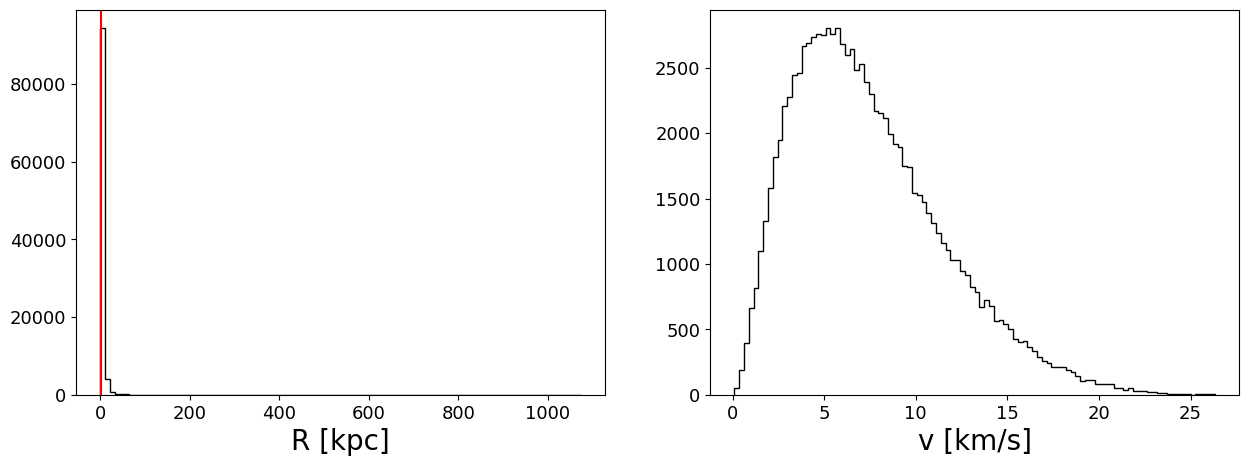

In [3]:
# Define the 
config = SimulationConfig(N_particles=1_000_02, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1_000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC_LAXMAP,
                          batch_size=25_000,   
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (10.0 * u.kpc).to(code_units.code_length).value,
                                               c = 0.0),
                          G=G, ) 

print(config)
print(params)
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
initial_state = construct_initial_state(positions, velocities)


#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()




In [8]:
from jax.sharding import PositionalSharding
import equinox as eqx

sharding = PositionalSharding(jax.devices())
G = jax.local_device_count()

shared_positions = jax.device_put(positions, sharding.reshape(G, 1))
# shared_positions = eqx.filter_shard(positions, sharding)

print(shared_positions.shape)
print(shared_positions.devices())



(100002, 3)
{CudaDevice(id=1), CudaDevice(id=0)}


In [9]:
from jax.debug import visualize_array_sharding
import matplotlib as mpl

def visualize(tensor, color_map="Set3"):
    visualize_array_sharding(tensor, color_map=mpl.colormaps[color_map])
   
visualize(shared_positions)

         
         
  GPU 0  
         
         
         
         
         
  GPU 1  
         
         
         

In [54]:
position_replicated = jax.device_put(positions)

In [ ]:
from jax.experimental.shard_map import shard_map


# 🚀 **Step 3: Compute Pairwise Distances Efficiently**
def compute_local_forces(local_positions, global_positions):
    """Compute sum of forces for a sharded chunk."""
    local_diff = local_positions[:, None] - global_positions[None, :]
    
    print(local_diff.shape)
    # Sum over all particles for each local piece
    return jnp.sum(local_diff, axis=1)

# 🚀 **Step 4: Parallelize Across GPUs Using `pmap`**
parallel_force_computation = shard_map(compute_local_forces, )

# Run computation
forces = parallel_force_computation(shared_positions, position_replicated)


TypeError: shard_map() missing 3 required positional arguments: 'mesh', 'in_specs', and 'out_specs'

# shard map 

In [4]:
from functools import partial

import jax
import jax.numpy as jnp

from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
from jax.experimental.shard_map import shard_map

In [5]:
mesh = jax.make_mesh((3, 1), ('x', 'y'))

shared_positions= jax.device_put(positions, NamedSharding(mesh, P('x', 'y')))
position_replicated = jax.device_put(positions)
                                 
@partial(shard_map, mesh=mesh, in_specs=(P('x', 'y'), P('y', None)), out_specs=P('x', None))
def reciprocal_distance(global_position, local_position):
    distance = global_position - local_position
    print(distance.shape)   
    return distance

distances = reciprocal_distance(position_replicated, shared_positions)

E0311 16:09:18.593260 4050202 pjrt_stream_executor_client.cc:3026] Execution of replica 0 failed: INTERNAL: NCCL operation ncclGroupEnd() failed: unhandled cuda error (run with NCCL_DEBUG=INFO for details). Last NCCL warning(error) log entry (may be unrelated) 'ncclProxyClientGetFd call to tpRank 0 handle 0x7dde5a113b00 failed : 3'.
E0311 16:09:18.593260 4050199 pjrt_stream_executor_client.cc:3026] Execution of replica 0 failed: INTERNAL: NCCL operation ncclGroupEnd() failed: unhandled cuda error (run with NCCL_DEBUG=INFO for details). Last NCCL warning(error) log entry (may be unrelated) 'ncclProxyClientGetFd call to tpRank 0 handle 0x7dde5a113b00 failed : 3'.
E0311 16:09:18.593320 4050205 pjrt_stream_executor_client.cc:3026] Execution of replica 0 failed: INTERNAL: NCCL operation ncclGroupEnd() failed: unhandled cuda error (run with NCCL_DEBUG=INFO for details). Last NCCL warning(error) log entry (may be unrelated) 'ncclProxyClientGetFd call to tpRank 0 handle 0x7dde5a113b00 failed :

XlaRuntimeError: INTERNAL: NCCL operation ncclGroupEnd() failed: unhandled cuda error (run with NCCL_DEBUG=INFO for details). Last NCCL warning(error) log entry (may be unrelated) 'ncclProxyClientGetFd call to tpRank 0 handle 0x7dde5a113b00 failed : 3'.: while running replica 0 and partition 0 of a replicated computation (other replicas may have failed as well).